- KEYWORDS: integration, quad, zeros, shape, enumerate, solve_ivp



# Solutions to first-order differential equations by integration



Adapted from Ch. 2 in Advanced Engineering Mathematics, 2<sup>nd</sup> Ed. by Michael Greenberg.




## Homogeneous, first-order linear differential equations



We first consider a homogeneous, first-order, linear differential equation of the form:

$y' + p(x) y = 0$, with $y(a) = b$ as an initial value.

You can derive a solution to this ODE as:

$y(x) = b e^{-\int_a^x p(\xi) d\xi}$

For concreteness, consider $(x+2) y' - xy = 0, y(0) = 3$

what is the value of $y(1)$?

We need to cast this in the form required to identify $p(x)$. That form is:

$y' + \frac{-x}{x+2}y = 0$.

Now, we simply evaluate the required integral and use it to compute the value of the solution at the desired new $x$ value.



In [1]:
a = 0
b = 3
x1 = 1

def p(x):
    return -x / (x + 2)

import numpy as np
from scipy.integrate import quad

I, err = quad(p, a, x1)

y_x1 = b * np.exp(-I)

print(f'y(1) = {y_x1:1.3f}')

y(1) = 3.624

It is a little trickier to evaluate the solution at several x-values, e.g. to make a plot. The `quad` function is not "vectorized", meaning it only performs one integral for one range at a time. You cannot pass it a list of ranges to evaluate it several times. Instead, we have to use a loop for this. In the loop, we will solve the integral, and accumulate the result in a solution array. Before we do that, here are a few useful commands we will need to use.

First, it is useful to make an array to store the results in. There are a few ways to do this, the one we use today is the `np.zeros` function. You specify the size of the array as an argument. For example, to make an array with three zeros, do this:



In [1]:
np.zeros(3)

array([ 0.,  0.,  0.])

Second, it is helpful to get the shape of an array. You use dot notation and the shape attribute of an array for this. This allows you to create an array, and later make an array of zeros with the same shape and size.



In [1]:
x = np.linspace(0, 3.5)
x.shape

(50,)

Finally we will iterate over the elements of the x array, and in each step we need to know the index of the element *and* the value of the element. `enumerate` provides this in a pretty straightforward syntax. This function iterates over an array and returns at each step the index and element, which you can assign to variables that you use inside the loop. There are other ways to achieve this, but we only consider this method today. Here, we create an array, and an array of zeros that is the same shape. Then, we iterate over the first array, and set the corresponding index in the second array equal to a computation using the index and element value.



In [1]:
arr = np.linspace(0, 1, 5)
new_arr = np.zeros(arr.shape)
print(f'Before the loop new_arr = {new_arr}')

for i, val in enumerate(arr):
    new_arr[i] = i * val
    print(f'The element at index {i} is {val}')

print(f'After the loop new_arr = {new_arr}')

Before the loop new_arr = [ 0.  0.  0.  0.  0.]
The element at index 0 is 0.0
The element at index 1 is 0.25
The element at index 2 is 0.5
The element at index 3 is 0.75
The element at index 4 is 1.0
After the loop new_arr = [ 0.    0.25  1.    2.25  4.  ]

Back to the solution to our integration problem. Our goal is to compute the value of the solution for an array of x-values. We will iterate over an array of x-values, and for each one compute the value of the solution at that x, and save the solution in a new array.



(0.0, 3.5)

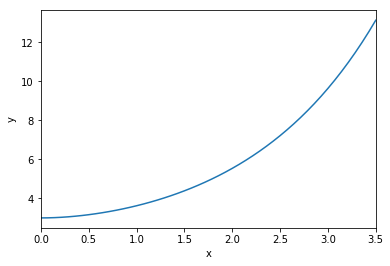

In [1]:
x = np.linspace(0, 3.5)
y = np.zeros(x.shape)

for i, x1 in enumerate(x):
    I, err = quad(p, a, x1)
    y[i] = b * np.exp(-I)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([x.min(), x.max()])

We should ask, how can we tell this is correct? We can confirm the initial values, which we know are correct.



In [1]:
x[0], y[0]

(0.0, 3.0)

We can express the ODE as: $y' = \frac{x}{x+2}y$. By inspection, we can see that the derivative will always be positive, so the solution should increase from the initial value, which it does.

We can also examine the derivatives of our solution. We have to rely on numerical derivatives of our solution because x and y are arrays. `np.gradient` will compute the derivative using a reasonable approximation. We know the derivative analytically from the ODE.



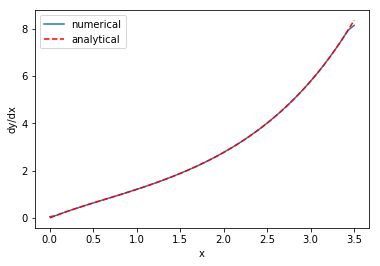

In [1]:
dydx = np.gradient(y, x)

plt.plot(x, dydx, label='numerical')
plt.plot(x, x / (x + 2) * y, 'r--', label='analytical')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()

Here you see good agreement over most of the range. The end-points are always less accurate because the derivatives there are approximated by a less accurate formula. We interpret the sum of this evidence to mean our solution to the ODE is good over this range of x values.




## Non-homogeneous linear first-order ODEs



A non-homogenous first order, linear differential equation has this form:

$y' + p(x) y = q(x), y(a)=b$

Equations of this form are typically solved with a method called variation of parameters. In the most general form, this leads to solutions of the form:

$y(x) = e^{-\int_a^x p(\xi)d\xi}\left(\int_a^x e^{-\int_a^{\xi} p(\zeta)d\zeta} q(\xi)d\xi + b\right)$

It is a little tricky to implement this. It is helpful to break this down into several pieces. Note that it is not necessary to do this, it just makes it easier to read, debug, and see that you have done it correctly. Here are the easiest parts.



In [1]:
def p(xi):
    return -2 * xi

def q(xi):
    return np.sin(xi)

a = 0
b = 3

Next, we will break the equation into two parts:

$y(x) = term1 * term2$ where

$term1 = e^{-\int_a^x p(\xi)d\xi}$

and

$term2 = \left(\int_a^x e^{-\int_a^{\xi} p(\zeta)d\zeta} q(\xi)d\xi + b\right)$

We can immediately define a function for term1 as:



In [1]:
def term1(x):
    I1, _ = quad(p, a, x)
    return np.exp(-I1)

term2 is a little trickier, as it has a partial integral inside an integral. We can define a function for this term also, but we have to define an internal function to use for the integral. The internal function will have an integral inside of it.



In [1]:
def term2(x):

    def integrand(xi):
        internal_term1, _ = quad(p, a, xi)
        internal_term2 = q(xi)
        return np.exp(internal_term1) * internal_term2

    I2, _ = quad(integrand, a, x)
    return I2 + b

Now, to use it, we form the product of the two terms:



In [1]:
x1 = 0.5
print(term1(x1) * term2(x1))

3.99127653383

With some algebra and calculus on your part, you might arrive at the following non-elementary integral solution:

$y(x) = e^{x^2} \left(\int_0^x e^{-\xi^2} \sin{\xi} d\xi + 3\right)$

The solution is called non-elementary because you cannot evaluate the integral in closed form using elementary functions, e.g. powers of x, trigonometric functions, exponentials or logarithms. You can, however, use numerical methods to integrate it.



In [1]:
def integrand(x):
    return np.exp(-x**2) * np.sin(x)

I, _ = quad(integrand, 0, x1)

sol = np.exp(x1**2) * (I + b)
sol

3.9912765338345242

Note there is some conservation of effort here. If you can derive the solution above correctly (and you have all learned how to do this if you had a differential equations course), the code below is quite short to get the solution at some value of x. If you are unable to derive that solution, you can use the general solution we gave, but then it is a trickier solution to implement in code.




## Limitations of solutions by integration



Solution by integration has some advantages. You get an estimate of the error in the solution from the `quad` function, which is helpful to know how good the solution is. However, the methods described above are limited to *linear* differential equations of the form described. If you have a nonlinear differential equation, or if you are unable to separate the equations into integrable form, the methods simply don't work. Next, we consider how to approach equations where we cannot use integration to solve the problems.




# Numerical solutions to differential equations



We begin with a brief review of first order differential equations. The equations we are concerned with here all have the form:

$\frac{dy}{dx} = f(x, y)$

And the value of the solution is known at some point, e.g. $y(x0) = y0$. $f(x, y)$ can be linear or nonlinear. Our goal in this section is to motivate how numerical solutions are obtained.

These notes were adapted from Chapter 6 in Advanced Engineering Mathematics 2<sup>nd</sup> ed. by Michael D. Greenberg.

The basic idea behind these methods is that we know the initial value of the solution *and* the derivative of the solution (it is defined by the ODE definition above), and so we can estimate the solution a small distance away from the initial value. If you repeat this process with the newly estimated point, you can estimate the next point, and so on. There are many algorithms for performing the estimation, and we will consider a two of them. These algorithms differ in efficiency, ease of implementation, and accuracy.




## Euler's method



The main idea of Euler's method is that if you know the value of the solution at some point, and you know the derivative at that point, you can estimate the solution nearby at $x0 + h$, where $h$ is a small number:

$y_{n+1} = y_n + f(x_n, y_n) h$

Now, you just repeat this until you get to the x-value that you want. For concreteness, consider:

$y' = y + 2x - x^2; y(0) = 1$.

This ODE has a known analytical solution: $y(x) = x^2 + e^x$. We will use this for comparison.



In [1]:
import numpy as np

def f(x, y):
    return y + 2 * x - x**2

x0 = 0
y0 = 1

x, h = np.linspace(x0, 1.5, 5, retstep=True)  # Note the optional argument to get the stepsize.
print(f'h = {h}')

y = np.zeros(x.shape)
y[0] = y0

# Implementation of Euler's method
for n in range(0, len(x) - 1):
    y[n + 1] = y[n] + f(x[n], y[n]) * h

h = 0.375

We can check out the solution graphically:



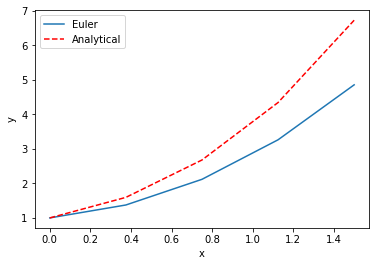

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y, label='Euler')
plt.plot(x, x**2 + np.exp(x), 'r--', label='Analytical')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

This solution does not look that good until you increase the number of points (i.e. decrease the value of $h$, significantly). It is known the error decreases only linearly with $h$.

**Exercise** Increase the number of points in the x array and see how it affects the solution.

This method is not used in practice; it is not very accurate, and you need quite small $h$ to get a good solution. It is used here to illustrate the idea of how one integrates a differential equation. We will consider one more advanced method, the fourth-order Runge-Kutta method.




## Fourth-order Runge-Kutta method



The general idea of the more advanced methods is to use a weighted average of slopes at various points around a point to best estimate the next function value. Here we consider the fourth-order Runge-Kutta algorithm. The terms are tedious to derive, and we will not do it here as they can be looked up in several places (e.g. [https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#The_Runge%E2%80%93Kutta_method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#The_Runge%E2%80%93Kutta_method)).



In [1]:
x0 = 0
y0 = 1

x, h = np.linspace(x0, 1.5, 5, retstep=True)
print(f'h = {h}')
y = np.zeros(x.shape)
y[0] = y0

# Implementation of fourth order Runge Kutta method
for i in range(0, len(x) - 1):
    k1 = h * f(x[i], y[i]) # Note this is like Euler's method
    k2 = h * f(x[i] + h / 2, y[i] + k1 / 2)  # This is the increment at the midpoint using y, k1
    k3 = h * f(x[i] + h / 2, y[i] + k2 / 2)  # This is the increment at the midpoint using y, k2
    k4 = h * f(x[i + 1], y[i] + k3) # This is the increment at the end of the interval
    # This is a weighted average of the four increments computed above. There is a heavier weight on the midpoints
    y[i + 1] = y[i] + (k1 + (2 * k2) + (2 * k3) + k4) / 6

h = 0.375

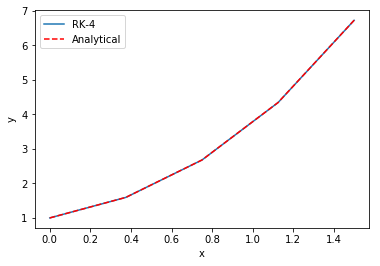

In [1]:
plt.plot(x, y, label='RK-4')
plt.plot(x, x**2 + np.exp(x), 'r--', label='Analytical')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Note you can get a much more accurate solution with a larger $h$ with this method.

*If* our differential equation is just $\frac{dy}{dt} = f(x)$, i.e. $f$ is independent of $y$, then this method is equivalent to Simpson't rule of integration.

Both of these methods leave some things to be desired:

1.  We had to code them, and there are many places to make mistakes.
2.  You have to choose $h$, or equivalently the number of points to use, and then make sure the solution has converged (does not depend on your choice).
3.  $h$ is fixed in these examples, and you might prefer to use an adaptive value.
4.  It is not easy to solve the inverse problem, e.g. for what value of $x$ does $y=4$?

In practice, there are well-written ODE integrators to solve this kind of problem that address all the short-comings listed above. To use them, we just need to learn the syntax. We do that next.




# scipy.integrate.solve\_ivp



The `scipy.integrate` library provides `solve_ivp` to solve first order differential equations. It is not the only one available, but this function is recommended. You import the function like this:



In [1]:
from scipy.integrate import solve_ivp

Here is a minimal use of the function, with keyword arguments.

`y0` is an array containing the initial values.  `fun` is a function with a signature of f(t, y). Here, $t$ is considered the independent variable. You can call it whatever you want, so f(x, y) is also fine. Since `solve_ivp` had $t$ in mind, the second argument is the `t_span`, which is a tuple of two numbers for where the integration starts (t0, or x0) and where it ends.  `solve_ivp` returns an object.



In [1]:
y0 = np.array([y0]) # It is a good idea to make y0 an array. It will be important later.
sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0)

The output of `solve_ip` is an object containing results in attributes on the object.



In [1]:
sol

message: 'The solver successfully reached the interval end.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.08034384,  0.86683456,  1.5       ])
 t_events: None
        y: array([[ 1.        ,  1.09011474,  3.13086569,  6.73191444]])

You should look for a few things here. One is that the message indicates success. Second, we access the solution using dot notation. Here are the independent variable values the solution was evaluated at.



In [1]:
sol.t

array([ 0.        ,  0.08034384,  0.86683456,  1.5       ])

Third, the solution is in a 2D array. We only have one equation here, so we use indexing to get the first row as an array.



In [1]:
sol.y[0]

array([ 1.        ,  1.09011474,  3.13086569,  6.73191444])

Now, we can plot the solution.



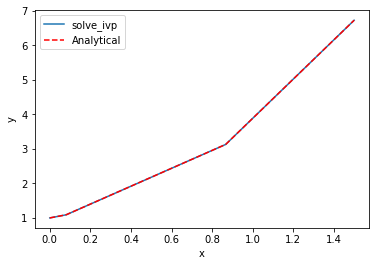

In [1]:
plt.plot(sol.t, sol.y[0], label='solve_ivp')
plt.plot(sol.t, sol.t**2 + np.exp(sol.t), 'r--', label='Analytical')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

That doesn't looks so great since there are only four data points. By default, the algorithm only uses as many points as it needs to achieve a specified tolerance. We can specify that we want the solution evaluated at other points using the optional `t_eval` keyword arg.



In [1]:
X = np.linspace(x0, 1.5)
sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, t_eval=X)
sol

message: 'The solver successfully reached the interval end.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.03061224,  0.06122449,  0.09183673,  0.12244898,
        0.15306122,  0.18367347,  0.21428571,  0.24489796,  0.2755102 ,
        0.30612245,  0.33673469,  0.36734694,  0.39795918,  0.42857143,
        0.45918367,  0.48979592,  0.52040816,  0.55102041,  0.58163265,
        0.6122449 ,  0.64285714,  0.67346939,  0.70408163,  0.73469388,
        0.76530612,  0.79591837,  0.82653061,  0.85714286,  0.8877551 ,
        0.91836735,  0.94897959,  0.97959184,  1.01020408,  1.04081633,
        1.07142857,  1.10204082,  1.13265306,  1.16326531,  1.19387755,
        1.2244898 ,  1.25510204,  1.28571429,  1.31632653,  1.34693878,
        1.37755102,  1.40816327,  1.43877551,  1.46938776,  1.5       ])
 t_events: None
        y: array([[ 1.        ,  1.03202273,  1.06688599,  1.10462029,  1.14526069,
         1.18883821,  

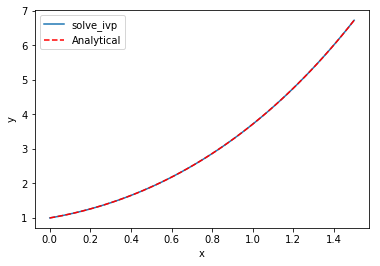

In [1]:
plt.plot(sol.t, sol.y[0], label='solve_ivp')
plt.plot(X, X**2 + np.exp(X), 'r--', label='Analytical')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

So far, `solve_ivp` solves the issues with item 1 (we did not have to code the algorithm), and items 2 and 3 (it uses an adaptive step and converges to a tolerance for us). It will also help us solve for the inverse problem, i.e. for what value of $x$ is $y=4$?

To do this, we need a new concept of an "event function". During each step of the integration, you can run a function that can detect an "event". When an event is detected, the location of the event is stored, and if desired integration can be terminated. `solve_ivp` can take a list of event functions. We consider only one for now.

An event occurs when an event function is equal to zero. During integration, if the event function changes sign, then it is clear an event has occurred, and the algorithm determines where it occurred. Since we want to know when $y=4$, we will define a function that returns $y - 4$, because that will equal zero at that condition. We want the integration to terminate when that happens, so we set the "terminal" attribute on our function to True.

An event function has a signature of f(x, y). Remember that $y$ is going to be an array,



In [1]:
def event1(x, y):
    return y[0] - 4

event1.terminal = True

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1)
sol

message: 'A termination event occurred.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([ 0.        ,  0.08034384,  0.86683456,  1.05797402])
 t_events: [array([ 1.05797402])]
        y: array([[ 1.        ,  1.09011474,  3.13086569,  4.        ]])

Now, there are a couple of new things to note. First, we got a message that a termination event occurred. Second, the sol.y array ends at 4.0, because we made the event function *terminal*. Next, sol.t\_events is not empty, because an event occurred. It now contains the value where the event occurred, which is where $y=4$!



In [1]:
sol.t_events[0]

array([ 1.05797402])

In [1]:
sol.t

array([ 0.        ,  0.08034384,  0.86683456,  1.05797402])

In [1]:
print(f'y=4 at x={sol.t[-1]}. Confirming: y = {sol.t[-1]**2 + np.exp(sol.t[-1])}')

y=4 at x=1.0579740235381914. Confirming: y = 3.9998382237380805

That is pretty close. You have to decide if it is close enough for the purpose you want. You can control the tolerance with optional `atol` and `rtol` keywords. You should read the documentation before changing this.



In [1]:
def event1(x, y):
    return y[0] - 4

event1.terminal = True

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1, rtol=1e-9)
sol
sol.t[-1]**2 + np.exp(sol.t[-1])

3.9999993427868006


# Summary



We learned how to solve different types of first-order differential equations. Linear equations can be solved by integration, which has the benefit of providing an estimate of error if the `scipy.integrate.quad` function is used.

Most first-order differential equations can be solved numerically with `scipy.integrate.solve_ivp`. This solver allows you to specify the points the solution is evaluated on, and to define event functions that can terminate the integration, or record where events occur.

